In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0768

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - loss: 0.0583
Average validation loss: 0.6302056312561035
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - loss: 0.0583 - val_loss: 0.6302
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 0.0407 - val_loss: 0.6302
Average validation loss: 0.5994169116020203
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - loss: 0.0407 - val_loss: 0.6148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - loss: 0.0311 - val_loss: 0.6148
Average validation loss: 0.5499021410942078
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - loss: 0.0311 - val_loss: 0.5932
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - loss: 2.8779e-04
Average validation loss: 0.93968066573143
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 876ms/step - loss: 2.8779e-04 - val_loss: 0.9397
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - loss: 2.8522e-04 - val_loss: 0.9397
Average validation loss: 0.3189575970172882
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 830ms/step - loss: 2.8522e-04 - val_loss: 0.6293
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - loss: 2.7416e-04 - val_loss: 0.6293
Average validation loss: 0.21102303266525269
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - loss: 2.7416e-04 - val_loss: 0.4899
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - loss: 1.1853e-04
Average validation loss: 0.132875207811594
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - loss: 1.1853e-04 - val_loss: 0.1329
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 834ms/step - loss: 1.0721e-04 - val_loss: 0.1329
Average validation loss: 0.07760716105500857
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 845ms/step - loss: 1.0721e-04 - val_loss: 0.1052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 854ms/step - loss: 1.0100e-04 - val_loss: 0.1052
Average validation loss: 0.11166749149560928
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 864ms/step - loss: 1.0100e-04 - val_loss: 0.1074
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 853ms/step - loss: 9.8993e-05 - val_loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 915ms/step - loss: 3.4780e-05
Average validation loss: 0.1898761624470353
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - loss: 3.4780e-05 - val_loss: 0.1899
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 828ms/step - loss: 2.5152e-05 - val_loss: 0.1899
Average validation loss: 0.3641839027404785
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 839ms/step - loss: 2.5152e-05 - val_loss: 0.2770
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 803ms/step - loss: 2.4203e-05 - val_loss: 0.2770
Average validation loss: 0.017035937402397394
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - loss: 2.4203e-05 - val_loss: 0.1904
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 817ms/step - loss: 2.1933e-05 - val_los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 836ms/step - loss: 3.2094e-05
Average validation loss: 0.054722676426172255
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 846ms/step - loss: 3.2094e-05 - val_loss: 0.0547
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 801ms/step - loss: 2.8015e-05 - val_loss: 0.0547
Average validation loss: 0.024664662778377533
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 811ms/step - loss: 2.8015e-05 - val_loss: 0.0397
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 793ms/step - loss: 2.1473e-05 - val_loss: 0.0397
Average validation loss: 0.06033600736409426
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 803ms/step - loss: 2.1473e-05 - val_loss: 0.0466
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 798ms/step - loss: 1.7777e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 804ms/step - loss: 3.8032e-05
Average validation loss: 0.023889398590351146
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - loss: 3.8032e-05 - val_loss: 0.0239
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 789ms/step - loss: 2.7353e-05 - val_loss: 0.0239
Average validation loss: 0.0556469454895705
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 799ms/step - loss: 2.7353e-05 - val_loss: 0.0398
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 794ms/step - loss: 2.2338e-05 - val_loss: 0.0398
Average validation loss: 0.02167798695154488
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 805ms/step - loss: 2.2338e-05 - val_loss: 0.0337
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 793ms/step - loss: 1.9096e-05 - val_lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 814ms/step - loss: 3.0801e-05
Average validation loss: 0.025310170743614434
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 825ms/step - loss: 3.0801e-05 - val_loss: 0.0253
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 786ms/step - loss: 2.2611e-05 - val_loss: 0.0253
Average validation loss: 0.04346955451183021
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 797ms/step - loss: 2.2611e-05 - val_loss: 0.0344
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 807ms/step - loss: 1.9700e-05 - val_loss: 0.0344
Average validation loss: 0.03127936095697805
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 818ms/step - loss: 1.9700e-05 - val_loss: 0.0334
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 784ms/step - loss: 1.6935e-05 - val_loss: 0.0334
Average validation loss: 0.0461178912082687
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 794ms/step - loss: 1.6935e-05 - val_loss: 0.0365
Epoch 5/10
40

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 796ms/step - loss: 3.1556e-05
Average validation loss: 0.02340146562103958
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 808ms/step - loss: 3.1556e-05 - val_loss: 0.0234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 805ms/step - loss: 1.8939e-05 - val_loss: 0.0234
Average validation loss: 0.009421611820774464
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 817ms/step - loss: 1.8939e-05 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 800ms/step - loss: 1.4053e-05 - val_loss: 0.0164
Average validation loss: 0.03380716690056337
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 812ms/step - loss: 1.4053e-05 - val_loss: 0.0222
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 155s 798ms/step - loss: 1.1631e-05 - va

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 798ms/step - loss: 9.2135e-06
Average validation loss: 0.028282770720709647
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - loss: 9.2135e-06 - val_loss: 0.0283
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 810ms/step - loss: 7.0848e-06 - val_loss: 0.0283
Average validation loss: 0.011339017822008048
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 822ms/step - loss: 7.0848e-06 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 809ms/step - loss: 5.4914e-06 - val_loss: 0.0198
Average validation loss: 0.008954695725281323
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 820ms/step - loss: 5.4914e-06 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 809ms/step - loss: 7.2319e-06
Average validation loss: 0.014225420440197922
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 821ms/step - loss: 7.2319e-06 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 796ms/step - loss: 6.0304e-06 - val_loss: 0.0142
Average validation loss: 0.04437303394661285
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 808ms/step - loss: 6.0304e-06 - val_loss: 0.0293
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 797ms/step - loss: 5.0162e-06 - val_loss: 0.0293
Average validation loss: 0.017003900138661265
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 809ms/step - loss: 5.0162e-06 - val_loss: 0.0252
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 792ms/step - loss: 4.2871e-06 - val_loss: 0.0252
Average validation loss: 0.011450903009972535
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 803ms/step - loss: 4.2871e-06 - val_loss: 0.0218
Saved 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 799ms/step - loss: 3.7306e-06
Average validation loss: 0.018007635523746204
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 810ms/step - loss: 3.7306e-06 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 794ms/step - loss: 2.8503e-06 - val_loss: 0.0180
Average validation loss: 0.012686777640030615
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 2.8503e-06 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 810ms/step - loss: 4.4068e-06 - val_loss: 0.0153
Average validation loss: 0.026226474282642204
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 822ms/step - loss: 4.4068e-06 - val_loss: 0.0190
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 234s 808ms/step - loss: 4.2599e-06 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 917ms/step - loss: 1.0658e-05
Average validation loss: 0.004683190654031932
80/80 ━━━━━━━━━━━━━━━━━━━━ 74s 928ms/step - loss: 1.0658e-05 - val_loss: 0.0047
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 804ms/step - loss: 6.2555e-06 - val_loss: 0.0047
Average validation loss: 0.004165909148287028
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 815ms/step - loss: 6.2555e-06 - val_loss: 0.0044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 824ms/step - loss: 4.8032e-06 - val_loss: 0.0044
Average validation loss: 0.00694366805255413
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 835ms/step - loss: 4.8032e-06 - val_loss: 0.0053
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 278s 895ms/step - loss: 4.1180e-06

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 798ms/step - loss: 7.5152e-06
Average validation loss: 0.011364443984348327
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 809ms/step - loss: 7.5152e-06 - val_loss: 0.0114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 788ms/step - loss: 5.4242e-06 - val_loss: 0.0114
Average validation loss: 0.010554178967140615
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 800ms/step - loss: 5.4242e-06 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 790ms/step - loss: 4.5264e-06 - val_loss: 0.0110
Average validation loss: 0.009701556312696388
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 801ms/step - loss: 4.5264e-06 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 799ms/step - loss: 1.1031e-05
Average validation loss: 0.009929425432346761
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 809ms/step - loss: 1.1031e-05 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 811ms/step - loss: 8.6831e-06 - val_loss: 0.0099
Average validation loss: 0.016319572273641825
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 822ms/step - loss: 8.6831e-06 - val_loss: 0.0131
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 793ms/step - loss: 6.9096e-06 - val_loss: 0.0131
Average validation loss: 0.019294826593250037
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 804ms/step - loss: 6.9096e-06 - val_loss: 0.0152
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 804ms/step - loss: 6.0156e-06 - val_loss: 0.0152
Average validation loss: 0.008780249980433533
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 815ms/step - loss: 6.0156e-06 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 795ms/step - loss: 1.1804e-05
Average validation loss: 0.00901076031408997
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 806ms/step - loss: 1.1804e-05 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 797ms/step - loss: 8.5324e-06 - val_loss: 0.0090
Average validation loss: 0.0065586301465777475
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 808ms/step - loss: 8.5324e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 793ms/step - loss: 6.8854e-06 - val_loss: 0.0078
Average validation loss: 0.007689935116407772
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 804ms/step - loss: 6.8854e-06 - val_loss: 0.0078
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 800ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 800ms/step - loss: 5.2112e-06
Average validation loss: 0.06983443638309836
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 811ms/step - loss: 5.2112e-06 - val_loss: 0.0698
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 794ms/step - loss: 3.6875e-06 - val_loss: 0.0698
Average validation loss: 0.01121012111834716
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 805ms/step - loss: 3.6875e-06 - val_loss: 0.0405
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 385s 794ms/step - loss: 3.1606e-06 - val_loss: 0.0405
Average validation loss: 0.007090069117839448
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 805ms/step - loss: 3.1606e-06 - val_loss: 0.0294
Saved model weights to 'c:\天_11157065\git\RipplesDetection\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 808ms/step - loss: 5.2127e-06
Average validation loss: 0.008691911487840116
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 819ms/step - loss: 5.2127e-06 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 796ms/step - loss: 3.8662e-06 - val_loss: 0.0087
Average validation loss: 0.01856150317238644
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 807ms/step - loss: 3.8662e-06 - val_loss: 0.0136
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 795ms/step - loss: 3.2173e-06 - val_loss: 0.0136
Average validation loss: 0.006478284688200802
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 806ms/step - loss: 3.2173e-06 - val_loss: 0.0112
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 646s 795ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 797ms/step - loss: 3.5274e-06
Average validation loss: 0.007376823676910741
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 3.5274e-06 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 385s 797ms/step - loss: 2.6360e-06 - val_loss: 0.0074
Average validation loss: 0.005111573254968486
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 808ms/step - loss: 2.6360e-06 - val_loss: 0.0062
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 579s 797ms/step - loss: 2.3214e-06 - val_loss: 0.0062
Average validation loss: 0.0049162611439290535
240/240 ━━━━━━━━━━━━━━━━━━━━ 582s 808ms/step - loss: 2.3214e-06 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetecti

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.308548743724823, 0.17564969785511494, 0.06624007270981869, 0.05779477202217095, 0.04733902127086185, 0.1040596445851649, 0.047292528190882886, 0.036653172532581574, 0.016707066211175903, 0.023061451073444914, 0.02228570983515561, 0.01197099158645142, 0.01761434336428162, 0.010549160738145777, 0.007407070742737132, 0.009644229396942719, 0.006952888597099899, 0.007351172296347398]
std_val_losses =  [0.2584353789656473, 0.17954995854602654, 0.057751710073579085, 0.07224502026955412, 0.08977273102248966, 0.10613960424037529, 0.05547824223165671, 0.06952779833370315, 0.01729793020989103, 0.017893414953691726, 0.04956597859283047, 0.02420374904423033, 0.04097902877082098, 0.011722587620083156, 0.0030045034504455176, 0.010113318994759538, 0.0044703753968417205, 0.010336565704840525]


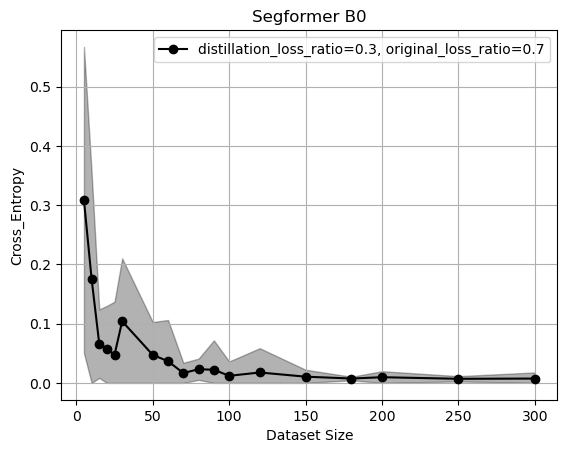

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()